### Thermally driven Convection -pt 3

Rheology ! 

**New concepts:** Viscosity as a function, non-linearity

In [1]:
%run "059-RayleighBenardConvection-setup-v2.py" # this has the buoyancy force term from pt 2

## The viscosity function

We previously defined 

```python
viscosity=1.0

stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = [freeslipBC,],
                            fn_viscosity  = viscosity, 
                            fn_bodyforce  = buoyancyFn )

```

but the stokes system is quite happy to accept an `underworld.function` as the viscosity.

For example, the Frank-Kamenetskii linearized viscosity:

$$
\eta = \eta_0 \exp(-CT)
$$

or the temperature / pressure dependent Arrhenius form:

$$
\eta = \eta_0 \exp \left(  \frac{ E^* + p V^* }{ T+ T_0 } \right)
$$

I'll show you how to do one of these, you can implement the other


In [2]:
## FK viscosity function

# 1. Let's make these values updateable 

eta0 = fn.misc.constant(1.0e6)
etaC = fn.misc.constant(13.815510557964274)

fk_viscosity_fn = eta0 * fn.math.exp( -1.0 * etaC * temperatureField)

location = (0.0,1.0)

print temperatureField.evaluate(location)
print fk_viscosity_fn.evaluate(location)

location = (0.0,0.0)

print temperatureField.evaluate(location)
print fk_viscosity_fn.evaluate(location)


[[ 0.]]
[[ 1000000.]]
[[ 1.]]
[[ 1.]]


In [3]:
## and load this into the stokes system

stokes.fn_viscosity = fk_viscosity_fn

Ra.value = 1.0e6


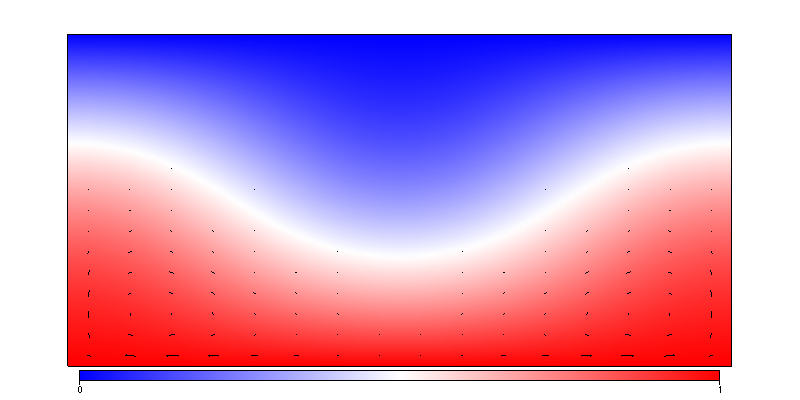

In [4]:
# Did that do anything ?

solver.solve()

# plot figure 

figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )
figtemp.show()


We can see if that worked ... 

In [5]:
time = 0.
step = 0
steps_end = 250

while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    step += 1
    

**Plot final temperature and velocity field**


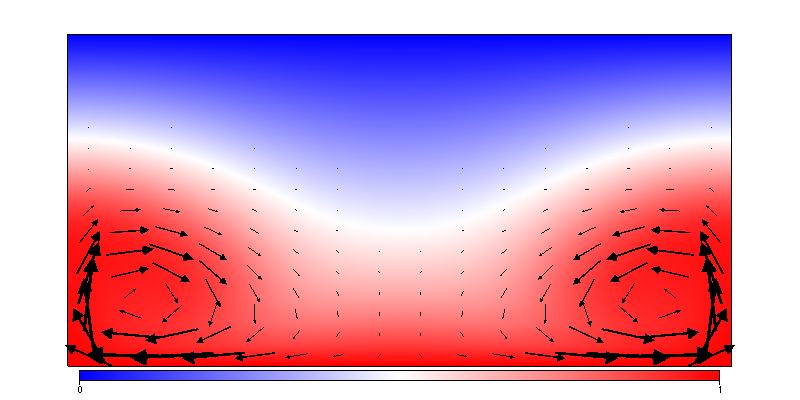

In [6]:
# plot figure

figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(Tmesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField / 100.0, arrowHead=0.2) )
figtemp.show()

### Exercise

You can try the Arrhenius rheology.

For numerical stability reasons, you might want to replace the true pressure with hydrostatic pressure (a constant times the depth).

The depth in the layer is 

```python
# assumes y increasing upwards from 0 to 1
fn_depth = 1.0 - fn.coord()[1] 
```



### Non-linear terms

Underworld can determine that a problem has a non linear constitutive equation (because it finds a reference to `velocityField` or `pressureField` (or whichever field names you use and load into the Stokes template). 

You might like to make a rheology which depends upon the second invariant of the strain rate tensor

```
strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

```

If you want to see some fancy tricks, including a damage rheology, see the Shear Banding notebooks in the Underworld examples directory.